In [56]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

from circuit_extract import visualize_circuit_masks
import circuit_extract as ce
import inference
import train

In [136]:
import importlib

importlib.reload(inference)
importlib.reload(train)
importlib.reload(ce)

<module 'circuit_extract' from '/home/cabbagepatch/Code/MI/vast/Mechanistic-Interpretability/circuit_extract.py'>

In [58]:
def model_config(ds_name: str, lr: float, epochs: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "epochs": epochs, 
        "lr": lr,
        # "pfrac": pfrac,
    }

def circuit_config(ds_name: str, lr: float, cepochs: int, k_w: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "cepochs": cepochs, 
        "lr": lr,
        "k_w": k_w,
    }
    

### Train Sparse Model ###

In [67]:
print("\n--- Phase 1: Initialize Model ---")
inp_shape = (1, 28, 28)
model = inference.CNN(nc=1, nf=16, num_classes=10, inp_shape=inp_shape)


--- Phase 1: Initialize Model ---


In [68]:
print("\n--- Phase 2: Train Sparse Baseline ---")
def scheduler(start, end, start_sparsity, target_sparsity, alpha):
    def f(epochs):
        t = min(max(0, epochs-start), end-start)/ (end-start)
        t = t**alpha
        return (target_sparsity* t + (1-t) * start_sparsity)
    return f

sched = scheduler(3, 12, 1, 0.1, 0.5)
# sched(0)
# for epoch in range(1,12):
#     print(sched(epoch+1))

cfg = model_config(ds_name='mnist', lr=1e-3, epochs=12)
device = cfg['device']
print(f"Running on {device}")

train.train_model(
    model=model,
    lr=cfg['lr'],
    b1=0.9, b2=0.999,
    # pfrac=cfg['pfrac'],
    scheduler = sched, 
    ds_name="mnist-baseline",
    eps=1e-8,
    epochs=cfg['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
Running on cpu
n_params 20432 n_params_wd 20432
cpu
Epoch 0 | Train Acc: 0.9536 | Test Acc: 0.9571
Epoch 1 | Train Acc: 0.9746 | Test Acc: 0.9754
Epoch 2 | Train Acc: 0.9812 | Test Acc: 0.9809
Epoch 3 | Train Acc: 0.9104 | Test Acc: 0.9127
Epoch 4 | Train Acc: 0.9262 | Test Acc: 0.9283
Epoch 5 | Train Acc: 0.9353 | Test Acc: 0.9388
Epoch 6 | Train Acc: 0.9410 | Test Acc: 0.9454
Epoch 7 | Train Acc: 0.9452 | Test Acc: 0.9471
Epoch 8 | Train Acc: 0.9490 | Test Acc: 0.9492
Epoch 9 | Train Acc: 0.9452 | Test Acc: 0.9463
Epoch 10 | Train Acc: 0.9425 | Test Acc: 0.9462
Epoch 11 | Train Acc: 0.9317 | Test Acc: 0.9336


In [69]:
print(f'CUDA available: {torch.cuda.is_available()}') 
print(f'Device count: {torch.cuda.device_count()}')
print(f'Current device: {torch.cuda.current_device() if torch.cuda.is_available() else None}')


CUDA available: False
Device count: 0
Current device: None


In [70]:
non_zero = sum([(p != 0).sum() for p in model.parameters()])
total = sum([p.numel() for p in model.parameters()])

print(f"{non_zero/total:.4f}")

# when retaining also retain other ones
# scheduler also add (50 percent of training steos then reach sparsity)
# iteratively sparsify features after starting from 0 percent sparsty
# circuits should not rely on 
# for every neuron retain some weights
# try pretraining on generation
#try on more complex datasets, cmnist, cifar10, pacs
#maybe try portability
#try training on
#try the weird loss thing
#mistake : apply sigmoid estimator
#see this as an angle to improve DG
#how to work with circuits that are not end to end // have to use bigger models
#ha405 // visual reasoning
#how to find neurons/circuits correspoding to sprurious features / circuits
#work with different circuits in cross-domain settings
#randomization makes network more generalizable
#maybe try and find work in compilers?
#LLMs ka kaam karo
#senior



0.0999


In [71]:
from copy import deepcopy


### Extracting circuit for each class

In [133]:
def run_class_circuit(class_idx: int, model, epochs=9, l0_lambda=0.05, lr=1e-3, mean_ablation=True):
    """
    Extracts and visualizes a circuit for a specific target class (0-9).
    """
    print(f" Processing Class {class_idx} ")
    
    ds_name = f"mnist-class-{class_idx}"
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Configuration: Device={device}, Lambda={l0_lambda}, Dataset={ds_name}")

    circuit = train.extract_circuit(
        model=deepcopy(model),
        lr=lr,
        b1=0.9, b2=0.999,
        ds_name=ds_name,     
        eps=1e-8,
        epochs=epochs,
        device=device,
        l0_lambda=l0_lambda,
        seed=42,
        mean_ablation=mean_ablation
    )

    print(f"\n--- Visualizing Circuit for Class {class_idx} ---")
    
    try:
        visualize_circuit_masks(circuit) 
        
        import os
        if os.path.exists("circuit_visualization.png"):
            os.rename("circuit_visualization.png", f"circuit_viz_class_{class_idx}.png")
            print(f"Saved visualization to: circuit_viz_class_{class_idx}.png")
            
    except Exception as e:
        print(f"Visualization failed: {e}")

    return circuit

 Processing Class 0 
Configuration: Device=cpu, Lambda=30.0, Dataset=mnist-class-0


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Calculating mean activations...
Initializing Circuit...
Initializing Optimizer...
Extracting Circuit (L0 Lambda=30.0)...
Epoch 0 | Loss: 26.5694 | Avg Mask: -0.178 | Total Non-Zero: 3830.0 | | Circuit Acc: 0.7743
Epoch 1 | Loss: 1.3397 | Avg Mask: -0.927 | Total Non-Zero: 621.0 | | Circuit Acc: 0.9671
Epoch 2 | Loss: 1.0409 | Avg Mask: -0.941 | Total Non-Zero: 502.0 | | Circuit Acc: 0.9880
Epoch 3 | Loss: 0.8598 | Avg Mask: -0.950 | Total Non-Zero: 422.0 | | Circuit Acc: 0.9865
Epoch 4 | Loss: 0.8020 | Avg Mask: -0.954 | Total Non-Zero: 413.0 | | Circuit Acc: 0.9900
Epoch 5 | Loss: 0.7923 | Avg Mask: -0.956 | Total Non-Zero: 395.0 | | Circuit Acc: 0.9902
Epoch 6 | Loss: 0.7667 | Avg Mask: -0.957 | Total Non-Zero: 393.0 | | Circuit Acc: 0.9897
Epoch 7 | Loss: 0.7547 | Avg Mask: -0.958 | Total Non-Zero: 382.0 | | Circuit Acc: 0.9938
Epoch 8 | Loss: 0.7381 | Avg Mask: -0.959 | Total Non-Zero: 375.0 | | Circuit Acc: 0.9958
Epoch 9 | Loss: 0.7220 | Avg Mask: -0.959 | Total Non-Zero: 360.0 |

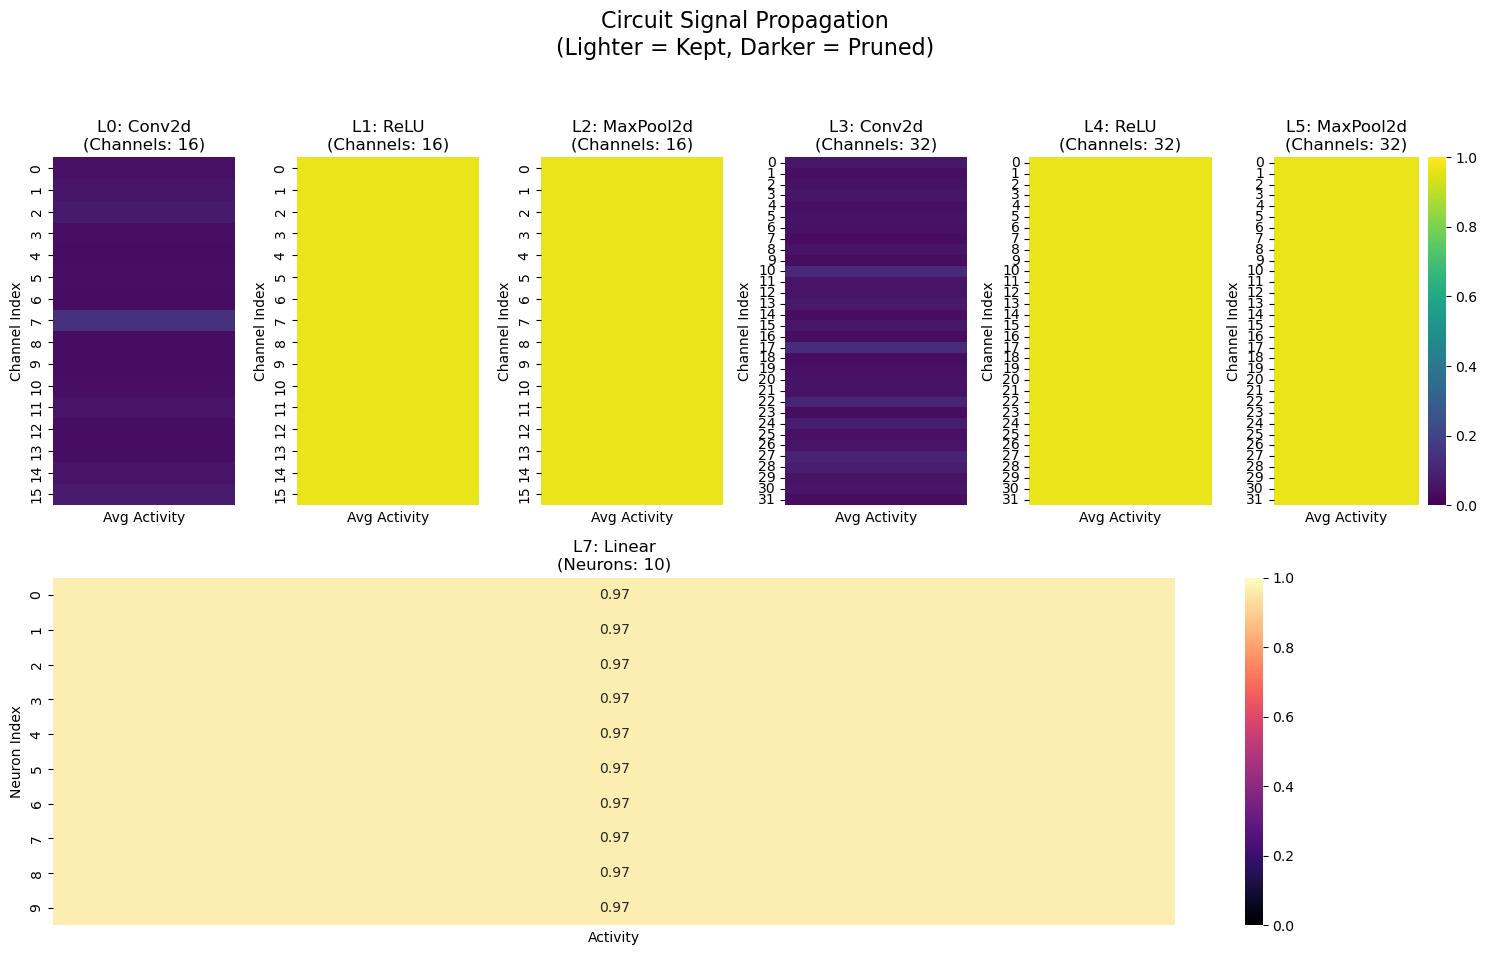


Visualization saved to circuit_visualization.png
Saved visualization to: circuit_viz_class_0.png


In [249]:
circuit_0 = run_class_circuit(class_idx=0, model=model, epochs=10,l0_lambda=3e+1, lr=1e-1, mean_ablation=True)

In [138]:
x = torch.randn(1,1,28,28)
circuit_0(x)

tensor([[22.0588, 20.6570, 22.1060, 22.4632, 22.1581, 22.6272, 21.9322, 22.2696,
         23.3287, 22.6657]], grad_fn=<AddBackward0>)

In [139]:
x = torch.randn(1,1,28,28)
circuit_0(x)


tensor([[22.0608, 20.6570, 22.1097, 22.4666, 22.1581, 22.6272, 21.9322, 22.2696,
         23.3287, 22.6657]], grad_fn=<AddBackward0>)

In [107]:
# for p1, p2 in zip(circuit_1.model.parameters(), model.parameters()):
#     print(torch.sum(p1-p2 !=0))



In [250]:
def active_neurons(circuit: torch.nn.Module):
    flattened_masks = []
    for mask in circuit.masks:
        if mask.active:
            flattened_masks.append(mask.mask.flatten())
    
    concatenated = torch.cat(flattened_masks, dim=0)
    return torch.nonzero(concatenated > 0).squeeze()

def toggle_neurons(circuit: torch.nn.Module, idxs: torch.Tensor):
    flattened_masks = []
    for mask in circuit.masks:
        if mask.active:
            flattened_masks.append(mask.mask.flatten())

    full_vector = torch.cat(flattened_masks, dim=0)

    full_vector[idxs] *= -1

    start_idx = 0
    with torch.no_grad():
        for mask in circuit.masks:
            if mask.active:
                numel = mask.mask.numel()
                chunk = full_vector[start_idx : start_idx + numel]
                mask.mask.copy_(chunk.view(mask.mask.shape))
                start_idx += numel

def invert_masks(circuit: torch.nn.Module):
    with torch.no_grad(): 
        for mask in circuit.masks:
            if mask.active:
                mask.mask.mul_(-1) 

In [251]:
def class_wise_acc(model, loader, classes, device):
    model.eval()
    model.to(device)

    epsilon = 1e-8
    correct = {cls:0 for cls in classes}
    total = {cls:epsilon for cls in classes}

    with torch.no_grad():
        for X,Y in loader:
            X, Y = X.to(device), Y.to(device)
            logits = model(X)
            preds = logits.argmax(dim=1)
            
            for i,cls in enumerate(classes):

                correct[cls] += torch.sum((preds == i) & (Y == i))
                total[cls] += torch.sum(Y==i)

    return {cls:correct[cls]/total[cls] for cls in classes}


In [239]:
trainloader, testloader = train.load_dataset("mnist-baseline")


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [255]:
circuit_0.mean_ablation

True

In [256]:
circuit_0.mean_ablation = False

In [261]:
invert_masks(circuit_0)


In [257]:
active_neurons(circuit_0)

tensor([    0,     1,     2,  ..., 18813, 18814, 18815])

In [262]:
class_wise_acc(circuit_0, testloader, [0,1,2,3,4,5,6,7,8,9], device)

{0: tensor(0.3010),
 1: tensor(0.9956),
 2: tensor(0.8934),
 3: tensor(0.9356),
 4: tensor(0.8676),
 5: tensor(0.8464),
 6: tensor(0.7223),
 7: tensor(0.9426),
 8: tensor(0.7885),
 9: tensor(0.7582)}

In [244]:
neurons = active_neurons(circuit_0)

In [247]:
invert_masks(circuit_0)
toggle_neurons(circuit_0, neurons)

for neuron in neurons[:10]:
    toggle_neurons(circuit_0, [neuron])
    print(class_wise_acc(circuit_0, testloader, [0,1,2,3,4,5,6,7,8,9], device))


{0: tensor(1.), 1: tensor(0.), 2: tensor(0.), 3: tensor(0.), 4: tensor(0.), 5: tensor(0.), 6: tensor(0.), 7: tensor(0.), 8: tensor(0.), 9: tensor(0.)}
{0: tensor(1.), 1: tensor(0.), 2: tensor(0.), 3: tensor(0.), 4: tensor(0.), 5: tensor(0.), 6: tensor(0.), 7: tensor(0.), 8: tensor(0.), 9: tensor(0.)}
{0: tensor(1.), 1: tensor(0.), 2: tensor(0.), 3: tensor(0.), 4: tensor(0.), 5: tensor(0.), 6: tensor(0.), 7: tensor(0.), 8: tensor(0.), 9: tensor(0.)}
{0: tensor(1.), 1: tensor(0.), 2: tensor(0.), 3: tensor(0.), 4: tensor(0.), 5: tensor(0.), 6: tensor(0.), 7: tensor(0.), 8: tensor(0.), 9: tensor(0.)}
{0: tensor(1.), 1: tensor(0.), 2: tensor(0.), 3: tensor(0.), 4: tensor(0.), 5: tensor(0.), 6: tensor(0.), 7: tensor(0.), 8: tensor(0.), 9: tensor(0.)}
{0: tensor(1.), 1: tensor(0.), 2: tensor(0.), 3: tensor(0.), 4: tensor(0.), 5: tensor(0.), 6: tensor(0.), 7: tensor(0.), 8: tensor(0.), 9: tensor(0.)}
{0: tensor(1.), 1: tensor(0.), 2: tensor(0.), 3: tensor(0.), 4: tensor(0.), 5: tensor(0.), 6: 

tensor(1)


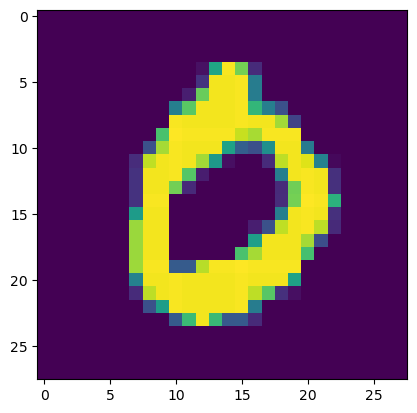

In [ ]:

# X, Y = next(iter(testloader))
# idx = 3
# plt.imshow(X[idx].squeeze())
# print(Y[idx])

In [ ]:
circuit_1 = run_class_circuit(1, model)

In [ ]:
circuit_2 = run_class_circuit(2, model)

In [ ]:
circuit_3 = run_class_circuit(3, model)

In [ ]:
circuit_4 = run_class_circuit(4, model)

In [ ]:
circuit_5 = run_class_circuit(5, model)

In [ ]:
circuit_6 = run_class_circuit(6, model)

In [ ]:
circuit_7 = run_class_circuit(7, model)

In [ ]:
circuit_8 = run_class_circuit(8, model)

In [ ]:
circuit_9 = run_class_circuit(9, model)

### Finetuned layer

In [ ]:
print("\n--- Phase 2: Train Sparse Baseline ---")
train.finetune(
    model=model,
    num_classes=2,
    lr=cfg['baseline']['lr'],
    b1=0.9, b2=0.999,
    ds_name="mnist-circuit",
    eps=1e-8,
    epochs=cfg['baseline']['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
n_params 23628 n_params_wd 23568


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0 | Train Acc: 0.9357 | Test Acc: 0.9456
Epoch 1 | Train Acc: 0.9511 | Test Acc: 0.9550
Epoch 2 | Train Acc: 0.9436 | Test Acc: 0.9498


In [64]:
# 3. Extract Circuit
print("\n--- Phase 3: Extract Circuit ---")
# Note: We pass the *trained* model to the circuit extractor
cfg['circuit']['l0_lambda'] = 0.0001
cfg['circuit']['lr'] = 1e-2
cfg['circuit']['epochs'] = 20
circuit = train.extract_circuit(
    model=model,
    lr=cfg['circuit']['lr'],
    b1=0.9, b2=0.999,
    ds_name="mnist-circuit",
    eps=1e-8,
    epochs=cfg['circuit']['epochs'],
    device=device,
    l0_lambda=cfg['circuit']['l0_lambda'],
    seed=cfg['seed']
)


--- Phase 3: Extract Circuit ---
Calculating mean activations...


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Initializing Circuit...
Extracting Circuit (L0 Lambda=0.0001)...
Epoch 0 | Loss: 4.3552 | Avg Mask: -1.278 | Total Non-Zero: 2337.0 | | Circuit Acc: 0.0434
Epoch 1 | Loss: 1.8895 | Avg Mask: -1.573 | Total Non-Zero: 1367.0 | | Circuit Acc: 0.5566
Epoch 2 | Loss: 1.6700 | Avg Mask: -1.780 | Total Non-Zero: 1140.0 | | Circuit Acc: 0.5740
Epoch 3 | Loss: 1.6140 | Avg Mask: -1.947 | Total Non-Zero: 971.0 | | Circuit Acc: 0.5545
Epoch 4 | Loss: 1.5956 | Avg Mask: -2.092 | Total Non-Zero: 911.0 | | Circuit Acc: 0.5580
Epoch 5 | Loss: 1.5883 | Avg Mask: -2.225 | Total Non-Zero: 867.0 | | Circuit Acc: 0.5582
Epoch 6 | Loss: 1.5836 | Avg Mask: -2.351 | Total Non-Zero: 821.0 | | Circuit Acc: 0.5423
Epoch 7 | Loss: 1.5765 | Avg Mask: -2.473 | Total Non-Zero: 773.0 | | Circuit Acc: 0.5486
Epoch 8 | Loss: 1.5830 | Avg Mask: -2.591 | Total Non-Zero: 755.0 | | Circuit Acc: 0.5336
Epoch 9 | Loss: 1.5876 | Avg Mask: -2.707 | Total Non-Zero: 740.0 | | Circuit Acc: 0.5346
Epoch 10 | Loss: 1.5878 | Avg Ma

In [73]:
x = circuit.masks[-6].mask.data

sum(x > 0) / x.numel()

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0003, 0.0006, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0003, 0.0000,
         0.0000, 0.0000, 0.0003, 0.0003, 0.0000],
        [0.0000, 0.0000, 0.0003, 0.0000, 0.0013, 0.0010, 0.0003, 0.0006, 0.0006,
         0.0000, 0.0000, 0.0003, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0016, 0.0022, 0.0013, 0.0016, 0.0000,
         0.0003, 0.0003, 0.0006, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0003, 0.0010, 0.0019, 0.0016, 0.0010, 0.0003,
         0.0000, 0.0000, 0.0006, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0006, 0.0010, 0.0013, 0.0013, 0.0013, 0.0003, 0.0000,
  